# 🎲 Board Games Analysis Project 🎲
----

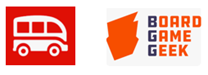

The **Board Game Analysis** project aims to explore and analyze data from **[BoardGameGeek](https://boardgamegeek.com/)** (also known as **BGG**), one of the largest online communities for board game enthusiasts. 

This project will delve into the characteristics of board games and their relationships with user ratings, providing insights into what makes a game highly rated and popular.

#### 🚀 Authors : Maxence Dauphin, Bernhard Riemer, Mónica Costa, Tahar Guenfoud, Konstantin Shapovalov
#### 🎯 Batch #1835 Data Science Flex



# Importing Libraries
------

In [ ]:
import os
import subprocess
import re

import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn import set_config; set_config(display="diagram")
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path

# Load data from Kaggle
---

⬇️ **Getting the data**

The project is based on a **BoardGameGeek** dataset coming from [Kaggle](https://www.kaggle.com/api/v1/datasets/download/melissamonfared/board-games). 

Once downloaded, the *archive.zip* obtained is stored inside the **raw_data** folder. Then, the archive is unzipped in order to extract the dataset as a *.csv file*. If the archive path already exists, we can ignore the download and re-use our previous data.

In [ ]:
# Define paths 
current_file_path = Path().absolute()  
raw_data_path = current_file_path / "raw_data"  
raw_data_path.mkdir(exist_ok=True)  # Create directory if it doesn't exist

# Download and extract data
kaggle_data_path = "https://www.kaggle.com/api/v1/datasets/download/melissamonfared/board-games"
archive_path = raw_data_path / "archive.zip"  # Path to zip file
subprocess.run(f"curl -L -o {archive_path} {kaggle_data_path}", shell=True) 
subprocess.run(f"unzip -o {archive_path} -d {raw_data_path}", shell=True)


The dataset (named df) can be open through the *read_csv* method of **pandas** :

In [ ]:
# Load the data
df_orig = pd.read_csv(raw_data_path / "BGG_Data_Set.csv", encoding='ISO-8859-1')
df = df_orig.copy()
df.shape




Once the dataset loaded, we can start exploring the data we have ! 🔎

# Exploratory Data Analysis (EDA)
---

⬇️ **Exploratory Data analysis** 

Let's get familiar with the dataset first :
- How does it look like ?
- What are the rows ? 
- What are the columns ?
- What is the shape of the dataset ?


In [ ]:
df.head(2)

In [ ]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

Is there any duplicates inside the dataset ?

In [ ]:
# DUPLICATES
df.duplicated().sum()

In [ ]:
df.info()

In [ ]:
df.dtypes.value_counts()

In [ ]:
df.select_dtypes(include=["object"]).nunique().sort_values(ascending=False)

In [ ]:
df.select_dtypes(include=["float64"]).nunique().sort_values(ascending=False)

In [ ]:
df.select_dtypes(include=["int64"]).nunique().sort_values(ascending=False)

In [ ]:
df.describe()

#### 🤔 My reflections:

- convert column names to lowercase and replace spaces with underscores to facilitate using pandas df.name syntax
- remove the game ID column as it does not provide inherent information about the game's quality or rating
- remove rows where the value for owned_users is NaN
- replace missing values in the mechanics and domains columns with "unspecified"
- rework mechanics and domains columns which contains a list of strings
- we have numerous categorical values to encode: 19,974 for name, 7,379 for mechanics, and 40 for domains. To maintain a simple basic model, I removed the name column

TODO
- we need to rework the year_published column to handle NaN, 0, and negative values, which represent very old games dated "BC"
- we need to transform the list values in mechanics and domains into something more meaningful
- ...


#### 🛍️ Convert column names to lowercase and replace spaces with underscores to facilitate using pandas df.name syntax

In [ ]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Output the transformed column names
print(df.columns)

#### 🛍️ Remove the game ID column as it does not provide inherent information about the game's quality or rating

In [ ]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

In [ ]:
df.drop(columns=['id'], inplace=True)

In [ ]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

#### 🛍️ Remove rows where the value for owned_users is NaN

In [ ]:
df = df[df['owned_users'].notna()]

In [ ]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

#### 🛍️ Replace missing values in the mechanics and domains columns with "unspecified"

In [ ]:
print("Columns with missing values:", df.columns[df.isnull().any()])

Changing any NA value inside the mechanics / domains column into an "unspecified" mechanic / domain value. This ensure to not deal with NA values.

In [ ]:
df["mechanics"] = df["mechanics"].fillna("unspecified mechanic")
df["domains"] = df["domains"].fillna("unspecified domain")


**Note :** Since these columns values will be used as columns later, we should not use the same word to design an undertermined value. Thus, we specify either mechanic or domain behind "unspecified".

In [ ]:
print("Columns with missing values:", df.columns[df.isnull().any()])

#### 🛍️ Rework mechanics and domains columns which contains a list of strings

In [ ]:
df.mechanics

In [ ]:
def clean(text):
    """
    This function aims to clean a list of words. "
    It takes a string of words separated by a comma as an input,
    and returns the same string, but without space or slashes inbetween words.
    Ex :
    - Before a clean function: Action Drafting, Area Majority / Influence, ...
    - After a clean function: Action Drafting,Area Majority,Influence,...
    """
    # This part replace empty words between commas, and separate slashed words by a comma
    cln = re.sub(', ,', ' ', str(text))
    cln = cln.replace(" /",",")
    cln = cln.replace("/",",")
    #cln = cln.lower() # if it is case sensitive, might be good to lowercase.

    # This part enable to separate and join again the slashed words, and to get rid of spaces after the comma
    """
    Ex : 'Action', 'Drafting,...', -> 'Action Drafting,...'
    """
    cln = cln.split()
    cln = ' '.join(cln)
    cln = cln.split(', ')
    cln = ','.join(cln)
    return cln


Below an example of the clean function doing : 

In [ ]:
print("Before a clean function:\n", df_orig.Mechanics.iloc[4])
print("After a clean function:\n", clean(df_orig.Mechanics.iloc[4]))

We can apply the clean functions to both **mechanics** and **domains** columns : 

In [ ]:
df["mechanics"] = df["mechanics"].apply(clean)
df["domains"] = df["domains"].apply(clean)

Finally, we have a clean string of words separated by just a comma in each row :

In [ ]:
print("Mechanics column :\n", df.mechanics.head(5))
print("\nDomains column :\n",df.domains.head(5))

In order to get to know how many mechanics there are in the entire DataFrame, without an appropriate tool, we can already guess that we would have to go through the entire string each time, save each word or combination of words used, and check the next one to see if it's a new one or if it's already in the list... isn't there a tool to exactly do this ?

➡️ There is one 😉, and it's called **Vectorizing** ! (*see module 5.11. Natural Language Processing*)

We can effectively consider each row of mechanics and domains as a **bag of word** that we have to count, using *CountVectorizer()*. We just have to specify that each word is between commas thanks to the *token_pattern* argument (in order to just count the words or combination of words between commas, and not count *each* word inbetween the words, like 'as', 'and', etc.).

In [ ]:
# token_pattern founds :
# token_pattern = r"\w+\s*-*\w*\s*-*\w*\s*-*\w*\s*-*\w*\b"
# token_pattern = \w+(\s*-*\w*){0,3}\b # not working
token_pattern = r"([^,]+)"
mechanics_count_vectorizer = CountVectorizer(token_pattern = token_pattern)
domains_count_vectorizer = CountVectorizer(token_pattern = token_pattern)

mechanics_columns = mechanics_count_vectorizer.fit_transform(df['mechanics'])
domains_columns = domains_count_vectorizer.fit_transform(df['domains'])

vectorized_mechanics = pd.DataFrame(mechanics_columns.toarray(),
                                    columns = mechanics_count_vectorizer.get_feature_names_out()
                                    )
print(vectorized_mechanics.columns)

vectorized_domains = pd.DataFrame(domains_columns.toarray(),
                                    columns = domains_count_vectorizer.get_feature_names_out()
                                    )
print(vectorized_domains.columns)

❓ Can we now concatenate the DataFrame with our new vectorized mechanics and domains ? 

‼️ **But before that** you might have noticed that the indexes of DataFrame goes to 20342, but has 20320 items.
And that when you call for df.mechanics, it specifies that there are 20320 rows. 
But the final index row is *20319*, whereas the one from df is *20342*. 
Therefore, we have a mismatch of indexes. That will lead to some NA if we don't take care of this, because the concatenation (as the merge) will be done on the indexes !
That's why we're using the *.reset_index(drop=True)* method on our DataFrame : to reset the index and forces the match between both DataFrames.

➡️ After that, we can effectively concatenate the DataFrame with our new vectorized mechanics and domains, and drop the mechanics and domains columns !


In [ ]:
## test = pd.merge([df, vectorized_mechanics], axis = 1, join = 'inner', ignore_index=False)
df = df.copy().reset_index(drop=True)
df = pd.concat([df, vectorized_mechanics, vectorized_domains], axis = 1)
## test = test.merge(vectorized_mechanics, how='left', left_index=True, right_index = True)
# print(test)
df.drop(['mechanics', 'domains'], axis = 1, inplace = True)
df.head(5)

In [ ]:
df

In [ ]:
#df['mechanics'].str.split(',') #.isin([' Action Retrieval']).sum()
#df['mechanics'].str.split(',',expand=True) #.isin([' Action Retrieval']).sum()

Ideas to visualize (this [data-to-viz website](https://www.data-to-viz.com/) will help :D !) :
- Repartition of mechanics (using treemaps ?)
- A graph with bayes average as y, bgg rank as x, and i don't know how yet but a visual representation of the mechanics or domains on this graph

In [ ]:
df[vectorized_mechanics.columns].sum().sort_values(ascending = False)

#### 🛍️ Transform 'year_published' column to game_age to indicate the age of each game based on the year it was published

In [ ]:
df['year_published'].dtype

In [ ]:
df['year_published'].nunique()

In [ ]:
# Count rows where year_published = 0
count_year_published_zero = len(df[df['year_published'] == 0])
print(f"Rows where year_published == 0: {count_year_published_zero}")

# Count and print rows where year_published < 0
count_year_published_negative = len(df[df['year_published'] < 0])
print(f"Rows where year_published < 0: {count_year_published_negative}")
print(df[df['year_published'] < 0][['name', 'year_published']])

In [ ]:
# Creating new column game_age to indicate the age of each game based on the year it was published

# Define the current year
current_year = 2025

# Create a new column 'game_age' and drop old column 'year_published'
df['game_age'] = current_year - df['year_published']

df.drop(['year_published'], axis = 1, inplace = True)

In [ ]:
# BONUS: Assess memory usage and compress data by "downcasting" dtypes to the smallest possible values
df.dtypes

In [ ]:
df.memory_usage()

In [ ]:
def compress(df, **kwargs):
    """
    Reduces size of dataframe by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum()/ 1024
    print("old dataframe size: ", round(input_size,2), 'kB')

    in_size = df.memory_usage(index=True).sum()
    for type in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=type))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=type)
    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    print("optimized size by {} %".format(round(ratio,2)))
    print("new dataframe size: ", round(out_size / 1024,2), " kB")

    return df

compress(df)
df.memory_usage()

# BASELINE MODEL
---

In [ ]:
df_clean = df.copy()

## Data Visualization

Let's create some visualizations to better understand our dataset. We'll explore:

1. Distribution of average ratings
2. Relationship between complexity and average rating
3. Relationship between popularity (users rated) and average rating
4. Relationship between play time and ownership
5. Distribution of minimum recommended ages
# 
### These visualizations will help us identify patterns and relationships in our board game data.

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')  
sns.set_palette("viridis")  # Modern color palette


# 1. Distribution of rating_average
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['rating_average'], kde=True, color='darkblue')
plt.title('Distribution of Average Ratings', fontsize=14)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.tight_layout()
plt.show()


# 2. Correlation between complexity_average and rating_average
plt.figure(figsize=(10, 6))
sns.scatterplot(x='complexity_average', y='rating_average', data=df_clean, alpha=0.7)
# Add trend line
sns.regplot(x='complexity_average', y='rating_average', data=df_clean, 
            scatter=False, line_kws={"color": "red"})
plt.title('Relationship Between Complexity and Average Rating', fontsize=14)
plt.xlabel('Average Complexity', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.tight_layout()
plt.show()


# 3. Relationship between users_rated and rating_average
plt.figure(figsize=(10, 6))
sns.scatterplot(x='users_rated', y='rating_average', data=df_clean, alpha=0.6)
plt.title('Relationship Between Popularity and Average Rating', fontsize=14)
plt.xlabel('Number of Users Rated', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xscale('log')  # Logarithmic scale for better visualization
plt.tight_layout()
plt.show()


# 4. Comparison of owned_users versus play_time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='play_time', y='owned_users', data=df_clean, alpha=0.6)
plt.title('Relationship Between Play Time and Popularity', fontsize=14)
plt.xlabel('Play Time (minutes)', fontsize=12)
plt.ylabel('Number of Users Owning the Game', fontsize=12)
plt.xscale('log')  # Logarithmic scale for better visualization
plt.yscale('log')  # Logarithmic scale for better visualization
plt.tight_layout()
plt.show()


# 5. Distribution of min_age
plt.figure(figsize=(10, 6))
# Convert min_age to category for a bar chart
age_counts = df_clean['min_age'].value_counts().sort_index()
sns.barplot(x=age_counts.index, y=age_counts.values, palette='viridis')
plt.title('Distribution of Minimum Recommended Ages', fontsize=14)
plt.xlabel('Minimum Age', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Import visualization libraries
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# 1. Rating Distribution
fig = px.histogram(df_clean, x='rating_average', nbins=20, color_discrete_sequence=['darkblue'],
                  histnorm='probability density')

# Add density curve
hist_data = np.histogram(df_clean['rating_average'].dropna(), bins=20)
bin_centers = (hist_data[1][:-1] + hist_data[1][1:]) / 2
fig.add_trace(go.Scatter(x=bin_centers, y=hist_data[0]/sum(hist_data[0]), mode='lines', 
                        name='Density', line=dict(color='red', width=2, shape='spline')))

fig.update_layout(
    title="Distribution of Average Ratings",
    xaxis_title="Average Rating",
    yaxis_title="Number of Games",
    template="plotly_white"
)
fig.show()

In [ ]:
# 2. Complexity vs Rating
fig = px.scatter(df_clean, x='complexity_average', y='rating_average', opacity=0.7)
fig.update_layout(title="Relationship Between Complexity and Average Rating")
fig.show()

In [ ]:
# 3. Popularity vs Rating
fig = px.scatter(df_clean, x='users_rated', y='rating_average', opacity=0.6)
fig.update_layout(title="Relationship Between Popularity and Average Rating", xaxis_type="log")
fig.show()

In [ ]:
# 4. Play Time vs Ownership
fig = px.scatter(df_clean, x='play_time', y='owned_users', opacity=0.6)
fig.update_layout(title="Relationship Between Play Time and Popularity",
                 xaxis_type="log", yaxis_type="log")
fig.show()

In [ ]:
# 5. Evolution by Year
# Filter out extreme years
filtered_df = df_clean[(df_clean['year'] >= 1950) & (df_clean['year'] <= 2023)]
# Count games by year
yearly_counts = filtered_df['year'].value_counts().sort_index().reset_index()
yearly_counts.columns = ['Year', 'Count']
# Create line chart
fig = px.line(yearly_counts, x='Year', y='Count', markers=True)
fig.update_layout(
    title="Evolution of Games Published by Year",
    xaxis_title="Year Published", 
    yaxis_title="Number of Games"
)
fig.show()

In [ ]:
# we have numerous categorical values to encode: 19,974 for name, 7,379 for mechanics, and 40 for domains. To maintain a simple basic model, I removed the name column
df_clean.drop(columns=['name'], inplace=True)
df_clean.columns

The function below enable us to check for duplicates in the DataFrame columns (**[source](https://stackoverflow.com/questions/75394033/pipeline-columntransformer-valueerror-selected-columns-are-not-unique-in-dat)**). If there are, you might encounter mistakes on the cross_validation.

In [ ]:
def list_duplicates(seq):
  """A stack overflow solution to look for a duplicate in a string list"""
  seen = set()
  seen_add = seen.add
  # adds all elements it doesn't know yet to seen and all other to seen_twice
  seen_twice = set( x for x in seq if x in seen or seen_add(x) )
  # turn the set into a list (as requested)
  return list( seen_twice )

list_duplicates(df_clean.columns)

In [ ]:
# Split data into features (X) and target (y)
# We want to predict Average Ratings
X = df_clean.drop('rating_average', axis=1)
y = df_clean['rating_average']

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

#### categorical features

In [ ]:
df_clean.select_dtypes(include=["object"]).nunique().sort_values(ascending=False)

In [ ]:
categorical_features_unique = df_clean.select_dtypes(include=["object"]).nunique()
categorical_features_unique.sum()

In [ ]:
preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False)
)

preproc_categorical_baseline

#### numerical features

In [ ]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_numerical_baseline

In [ ]:
preproc_baseline = ColumnTransformer([
    ("num_transform", preproc_numerical_baseline, make_column_selector(dtype_include=np.number)),
    ("cat_transform", preproc_categorical_baseline, make_column_selector(dtype_exclude=np.number))
]).set_output(transform="pandas")

In [ ]:
pipeline_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor(max_depth=5))
pipeline_baseline

In [ ]:
cv_score = cross_val_score(pipeline_baseline, X_train, y_train, cv=5).mean()
print(f"Cross-validation score: {cv_score}")

In [ ]:
#pipeline_baseline.get_params()

In [ ]:
pipeline_baseline.fit(X_train, y_train)

In [ ]:
# Make predictions
y_pred = pipeline_baseline.predict(X_test)

Evaluate the model on the test set

In [ ]:
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

In [ ]:
import pickle
models_path = os.path.expanduser("~/code/maxencedauphin/bgg-project/models")
pickle_file_path = os.path.join(models_path, "pipeline_baseline.pkl")

if not os.path.exists(models_path):
        os.makedirs(models_path)
# Export Pipeline as pickle file
with open(pickle_file_path, "wb") as file:
    pickle.dump(pipeline_baseline, file)

print(f"Model saved to: {pickle_file_path}")